# Data Engineering Tools (DET): Feature-Engine

In [126]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
import numpy as np
import pandas as pd
pd.options.display.max_rows = 999
pd.options.display.max_columns = 99
import matplotlib.pyplot as plt
# library


# LOAD DATA

In [127]:
from sklearn.datasets import fetch_openml
dataset = fetch_openml(name="house_prices", as_frame=True)
col_y = dataset["target_names"]
col_x = dataset["feature_names"]
data = dataset["frame"]
data.shape

(1460, 81)

In [128]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   float64
 1   MSSubClass     1460 non-null   float64
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   float64
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   float64
 18  OverallC

# LIBRARY

## [IMPUTATION](https://feature-engine.readthedocs.io/en/1.3.x/user_guide/imputation/index.html)

In [129]:
# imputers
from feature_engine.imputation import MeanMedianImputer
from feature_engine.imputation import ArbitraryNumberImputer
from feature_engine.imputation import EndTailImputer
from feature_engine.imputation import CategoricalImputer
from feature_engine.imputation import RandomSampleImputer
# add indicator
from feature_engine.imputation import AddMissingIndicator
# drop records
from feature_engine.imputation import DropMissingData

### numerical imputation

In [158]:
# selected variable
var_sel = 'LotFrontage'

In [159]:
# set up the Mean/Median Imputer (only numerical)
median_imputer = MeanMedianImputer(
                   imputation_method='median',
                   variables=[var_sel]
                   )

# set up the Arbitrary Number (number selected by user) Imputer (only numerical)
arbitrary_imputer = ArbitraryNumberImputer(
    arbitrary_number=-99,
    variables=[var_sel],
    )
"""
# also possible
arbitrary_imputer = ArbitraryNumberImputer(
        imputer_dict = {'varA' : 1, 'varB': 99}
        )
"""

# set up the End Tail Imputer (only numerical)
tail_imputer = EndTailImputer(imputation_method='gaussian',
                          tail='right',
                          fold=3, # 3 times mean + (right) standard deviation
                          variables=[var_sel])

# set up the Categorical Imputer (numerical and categorical)
cat_imputer = CategoricalImputer(variables=[var_sel], imputation_method = 'frequent', ignore_format = True)

# set up the Random Sample Imputer (numerical and categorical)
random_imputer = RandomSampleImputer(
        random_state=[var_sel],
        seed='observation',
        seeding_method='add'
    )

In [160]:
# copy
dfnum= data[[var_sel]].copy()
# fit / transform
dfnum['median_imputer'] = median_imputer.fit_transform(data)[var_sel].values
dfnum['arbitrary_imputer'] = arbitrary_imputer.fit_transform(data)[var_sel].values
dfnum['tail_imputer'] = tail_imputer.fit_transform(data)[var_sel].values
dfnum['cat_imputer'] = cat_imputer.fit_transform(data)[var_sel].values
dfnum['random_imputer'] = random_imputer.fit_transform(data)[var_sel].values

<AxesSubplot:ylabel='Density'>

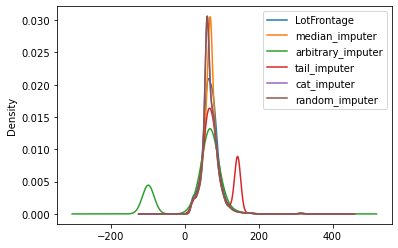

In [161]:
dfnum.plot(kind = "kde")

### categorical

In [179]:
# selected variable
var_sel = 'Alley' #'MasVnrType'

In [180]:
# set up the Categorical Imputer (numerical and categorical)
cat_imputer = CategoricalImputer(variables=[var_sel], imputation_method = 'frequent')

# set up the Random Sample Imputer (numerical and categorical)
random_imputer = RandomSampleImputer(
        variables=[var_sel],
        random_state=1,
        #random_state=[var_sel], 
        #seed='observation',
        #seeding_method='add'
    )

In [181]:
# copy
dfcat= data[[var_sel]].copy()
# fit / transform
dfcat['cat_imputer'] = cat_imputer.fit_transform(data)[var_sel].values
dfcat['random_imputer'] = random_imputer.fit_transform(data)[var_sel].values

In [182]:
dfcat[dfcat[var_sel].isnull()]

,Alley,cat_imputer,random_imputer
0,None,Grvl,Pave
1,None,Grvl,Grvl
2,None,Grvl,Grvl
3,None,Grvl,Grvl
4,None,Grvl,Grvl
...,...,...,...
1455,None,Grvl,Pave
1456,None,Grvl,Pave
1457,None,Grvl,Grvl
1458,None,Grvl,Grvl


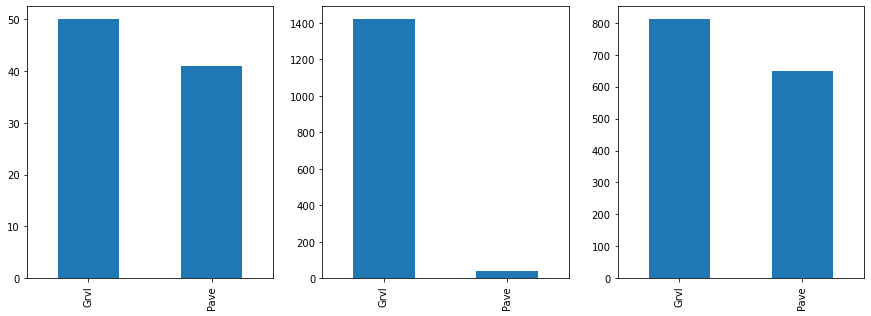

In [193]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize = (15,5))
dfcat[var_sel].value_counts().plot.bar(ax = ax1)
dfcat["cat_imputer"].value_counts().plot.bar(ax = ax2)
dfcat["random_imputer"].value_counts().plot.bar(ax = ax3)
plt.show()

### add indicator

In [194]:
# selected variable
var_sel = 'LotFrontage'

In [195]:
# set up the Add Missing Indicator (a new column XXX_na) (numerical and categorical)
addBinary_imputer = AddMissingIndicator(
variables=[var_sel],
)
# fit / transform
temp = addBinary_imputer.fit_transform(data)[[var_sel, f'{var_sel}_na']]
temp[temp[var_sel].isnull()].head()

,LotFrontage,LotFrontage_na
7,NaN,1
12,NaN,1
14,NaN,1
16,NaN,1
24,NaN,1


### remove records with missing values

In [196]:
# selected variable
var_sel = 'LotFrontage'

In [197]:
# set up the Drop Missing Data (numerical and categorical)
missingdata_imputer = DropMissingData(variables=[var_sel])
# fit / transform
temp = data[[var_sel]].copy()
temp_r = missingdata_imputer.fit_transform(temp)
temp.shape, temp_r.shape

((1460, 1), (1201, 1))